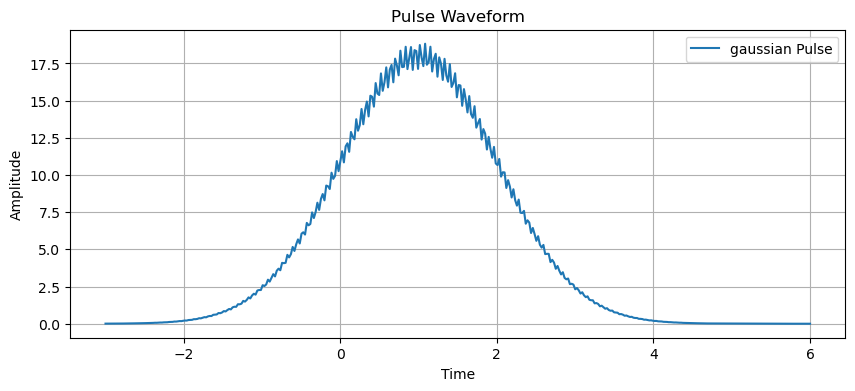

In [4]:
from CQEDModel import *
from Pulses import *
import qutip as qp
dur=1.0
fm=100.0
na=0.05
tlist=np.linspace(-3*dur,6*dur,400)
tlist0=np.linspace(-5*dur,6*dur,20000)
pulse1=Pulse(amplitude=18.0, frequency=0, phase=0, pulse_type="Gaussian", duration=dur, center=dur, noise=generate_pulse_noise\
             ,noiseamp=na,freqmult=fm)
pulse1.precomputing_noise(tlist0)

pulse2=Pulse(amplitude=18.0, frequency=0, phase=0, pulse_type="Gaussian", duration=dur, center=-dur, noise=generate_pulse_noise\
             ,noiseamp=na,freqmult=fm)
pulse2.precomputing_noise(tlist0)

Delta0=400.0
Pa=80.0
#Delta0=5000
#Pa=173.205
APulse=Pulse(amplitude=Pa, frequency=0, phase=0, pulse_type="Gaussian", duration=dur, center=dur, noise=generate_pulse_noise
             ,noiseamp=na,freqmult=fm)
APulse.precomputing_noise(tlist0)


cdur=dur/np.sqrt(2.0)
CPulse=Pulse(amplitude=-1/2*Pa**2/Delta0, frequency=0, phase=0, pulse_type="Gaussian",\
             duration=cdur, center=dur, noise=generate_pulse_noise,noiseamp=na,freqmult=fm)
CPulse.precomputing_noise(tlist0)
options1 = {"store_states": True, "progress_bar": True}
pulse1.plot_pulse(tlist)

In [ ]:
import numpy as np
import concurrent.futures

# Assume these functions and classes are already defined somewhere in your code
# def generate_dicke_state(...), DickeRaman, fidelity, etc.
dicke2 = generate_dicke_state(3, 1, 2)

def run_simulation(ka, dr):
    """Function to run a single simulation for a given `ka` and `dr`."""
    fl = np.array([])
    for a in range(10):
        Dc1 = DickeRaman(Nbits=3, Ncav=2, Det=48.0, tdet=0.0, spem=True, cavdecay=False)
        Dc1.construct_ham(pulse1, pulse2)
        Dc1.apply_dissipation(1.0, 1.0, ka)
        Dc1.inject_photon(npx=1.0, coherent=False)
        Dc1.apply_ACdispersive(Pa, APulse, Delta0)
        Dc1.apply_controlfield(CPulse)
        Dc1.introduce_globalpiswap(3.0 * dur, 0.01)
        Dc1.introduce_globalpiswap(6.0 * dur, 0.01)
        Dc1.introduce_drift(driftA=dr)
        Dc1.introduce_freqnoise(system="atomic", noise_type="Deterministic", sigma=[0.0, 0.0, 0.0], noise_freq=100.0)
        
        # Simulate and calculate fidelity
        #st1 = Dc1.simulate(tlist).states
        st1 = Dc1.simulate_mcwf(tlist,num_cpus=60, ntraj=1000,options=options1).states
        fl = np.append(fl, max([fidelity(x, dicke2) for x in st1]))
        st1 = []
    
    return np.min(fl)

def parallelize_simulations(kappalist, drlist):
    """Function to parallelize the nested loops."""
    # Prepare a list to hold all tasks (each combination of `ka` and `dr`)
    tasks = [(ka, dr) for ka in kappalist for dr in drlist]
    
    # Initialize an empty list to store the results
    fidelitylist = np.array([])
    
    # Use ProcessPoolExecutor to parallelize the tasks
    with concurrent.futures.ProcessPoolExecutor(max_workers=15) as executor:
        # Map each task to the `run_simulation` function
        results = executor.map(run_simulation, *zip(*tasks))  # Unpack the tasks list into separate arguments
        
        # Collect the results in fidelitylist
        fidelitylist = np.array(list(results))
    
    return fidelitylist

# Example usage:

kappalist = np.linspace(0.0, 0.2, 10)
drlist = np.linspace(0.0, 0.2, 10)

# Run the parallelized simulations
fidelitylist = parallelize_simulations(kappalist, drlist)

capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


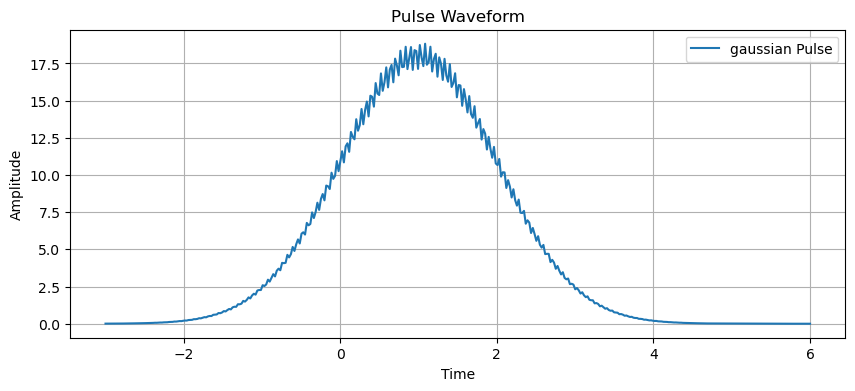

-3.552713678800501e-14

0.9860034281037672

In [3]:


Dc1=DickeRaman(Nbits=3, Ncav=2, Det=48.0, tdet=0.0, spem=True,cavdecay=False)
Dc1.construct_ham(pulse1, pulse2);
Dc1.apply_dissipation(1.0,1.0,0.05);
Dc1.inject_photon(npx=1.0,coherent = False);
Dc1.apply_ACdispersive(Pa,APulse,Delta0);
Dc1.apply_controlfield(CPulse);
Dc1.introduce_globalpiswap(3.0*dur,0.01)
Dc1.introduce_globalpiswap(6.0*dur,0.01)
display(Dc1.check_ACeffect())
Dc1.introduce_drift(driftA=0.05);
Dc1.introduce_freqnoise(system="atomic",noise_type="Deterministic",sigma=[0.0,0.0,0.0],noise_freq=100.0);
states=[]
#st1=Dc1.simulate_mcwf(tlist,num_cpus=60, ntraj=100,options=options1).states
st1=Dc1.simulate(tlist).states
dicke2=generate_dicke_state(3, 1, 2)
max([fidelity(x,dicke2) for x in st1])

drlist=np.linspace(0.0,0.2,10)
kappalist=np.linspace(0.0,0.2,10)
fidelitylist=np.array([])
dicke2=generate_dicke_state(3, 1, 2)
for ka in kappalist:
    for dr in drlist:
        fl=np.array([])
        for a in range(10):
            Dc1=DickeRaman(Nbits=3, Ncav=2, Det=48.0, tdet=0.0, spem=True,cavdecay=False)
            Dc1.construct_ham(pulse1, pulse2);
            Dc1.apply_dissipation(1.0,1.0,ka);
            Dc1.inject_photon(npx=1.0,coherent = False);
            Dc1.apply_ACdispersive(Pa,APulse,Delta0);
            Dc1.apply_controlfield(CPulse);
            Dc1.introduce_globalpiswap(3.0*dur,0.01)
            Dc1.introduce_globalpiswap(6.0*dur,0.01)
            display(Dc1.check_ACeffect())
            Dc1.introduce_drift(driftA=dr);
            Dc1.introduce_freqnoise(system="atomic",noise_type="Deterministic",sigma=[0.0,0.0,0.0],noise_freq=100.0);
            states=[]
            #st1=Dc1.simulate_mcwf(tlist,num_cpus=60, ntraj=100,options=options1).states
            st1=Dc1.simulate(tlist).states            
            fl=np.append(fl,max([fidelity(x,dicke2) for x in st1]))
        fidelitylist=np.append(fidelitylist,np.min(fl))

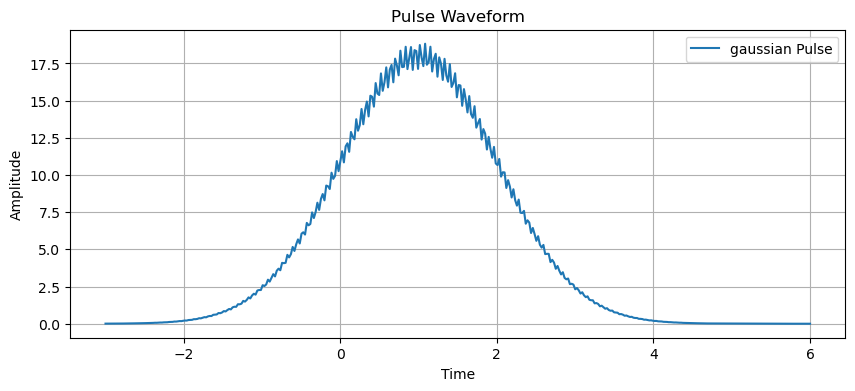

0.9991749285542314

0.9979714999106233

0.9967208338775055

0.9971061423146624

0.9979628248669764

array([0.99917493, 0.9979715 , 0.99672083, 0.99710614, 0.99796282])

0.9977616551000009

0.9980251968720176

0.9976089027099025

0.9973837678023771

0.9966910533373232

array([0.99917493, 0.9979715 , 0.99672083, 0.99710614, 0.99796282,
       0.99669105])

In [ ]:
'''
Nr=1
for i in range(Nr):
    Dc1=DickeRaman(Nbits=3, Ncav=2, Det=50.0, tdet=0.0, spem=True,cavdecay=False);
    Dc1.construct_ham(pulse1, pulse2);
    Dc1.apply_dissipation(0.0,0.0,0.0);
    Dc1.inject_photon(npx=1.0,coherent = False);
    Dc1.apply_ACdispersive(Pa,APulse,Delta0);
    Dc1.apply_controlfield(CPulse);
    Dc1.introduce_drift(driftA=0.1);
    Dc1.introduce_freqnoise(system="atomic",noise_type="Deterministic",sigma=[0.005,0.0,0.0],noise_freq=100.0);
    #st1=Dc1.simulate_mcwf(tlist,num_cpus=18, ntraj=1,options=options1).states;
    if states == []:
        states=st1;
    else:
        states=[x+y for x, y in zip(states, st1)];
states = [x/Nr for x in states]
dicke2=generate_dicke_state(3, 1, 2)
display(fidelity(states[-1],dicke2))
'''

Natoms=np.arange(2,7)
Nc=2
nd=1
fidelitiesl=np.array([])
stateslst=np.array([])

for n in Natoms:
    dicke2=generate_dicke_state(n, nd, Nc)
    #display(Dc1.check_ACeffect())
    flist_temp=np.array([])
    for i in range(11):
        Dc1=DickeRaman(Nbits=n, Ncav=Nc, Det=48.0, tdet=0.0, spem=True,cavdecay=True)
        Dc1.construct_ham(pulse1, pulse2);
        Dc1.apply_dissipation(0.0,0.0,0.0);
        Dc1.inject_photon(npx=nd,coherent = False);
        Dc1.apply_ACdispersive(Pa,APulse,Delta0);
        Dc1.apply_controlfield(CPulse);
        Dc1.introduce_globalpiswap(3.0*dur,0.01)
        Dc1.introduce_globalpiswap(6.0*dur,0.01)
        Dc1.introduce_drift(driftA=0.02);
        Dc1.introduce_freqnoise(system="atomic",noise_type="Deterministic",sigma=[0.0,0.0,0.0],noise_freq=20.0);
        sts0=Dc1.simulate_mcwf(tlist,num_cpus=60, ntraj=1,options=options1)
        sts=sts0.states
        flist_temp=np.append(flist_temp,max([fidelity(x,dicke2) for x in sts]))
    #statelst=np.append(stateslst,[sts])
    display(min(flist_temp))
    fidelitiesl=np.append(fidelitiesl,min(flist_temp))
display(fidelitiesl)

Nc=3
nd=2
fidelitiesl2=np.array([])
stateslst2=np.array([])
for n in Natoms:
    dicke2=generate_dicke_state(n, nd, Nc)
    #display(Dc1.check_ACeffect())
    flist_temp=np.array([])
    for i in range(11):
        Dc1=DickeRaman(Nbits=n, Ncav=Nc, Det=48.0, tdet=0.0, spem=True,cavdecay=True)
        Dc1.construct_ham(pulse1, pulse2);
        Dc1.apply_dissipation(0.0,0.0,0.0);
        Dc1.inject_photon(npx=nd,coherent = False);
        Dc1.apply_ACdispersive(Pa,APulse,Delta0);
        Dc1.apply_controlfield(CPulse);
        Dc1.introduce_globalpiswap(3.0*dur,0.01)
        Dc1.introduce_globalpiswap(6.0*dur,0.01)
        Dc1.introduce_drift(driftA=0.02);
        Dc1.introduce_freqnoise(system="atomic",noise_type="Deterministic",sigma=[0.0,0.0,0.0],noise_freq=10.0);
        sts0=Dc1.simulate_mcwf(tlist,num_cpus=60, ntraj=1,options=options1)
        sts=sts0.states
        flist_temp=np.append(flist_temp,max([fidelity(x,dicke2) for x in sts]))
    #statelst=np.append(stateslst,[sts])
    display(min(flist_temp))
    fidelitiesl2=np.append(fidelitiesl2,min(flist_temp))
display(fidelitiesl2)

In [6]:
import concurrent.futures
import numpy as np
'''
Natoms=np.arange(2,3)
fidelitiesl=np.array([])
stateslst=np.array([])
# Define your worker function that runs the calculations for each n
def process_atom(n, pulse1, pulse2, Pa, APulse, Delta0, CPulse, dur, tlist):
    Dc1 = DickeRaman(Nbits=n, Ncav=2, Det=48.0, tdet=0.0, spem=True, cavdecay=True)
    Dc1.construct_ham(pulse1, pulse2)
    Dc1.apply_dissipation(1.0, 1.0, 0.0)
    Dc1.inject_photon(npx=1.0, coherent=False)
    Dc1.apply_ACdispersive(Pa, APulse, Delta0)
    Dc1.apply_controlfield(CPulse)
    Dc1.introduce_globalpiswap(3.0 * dur, 0.01)
    Dc1.introduce_globalpiswap(6.0 * dur, 0.01)
    Dc1.introduce_drift(driftA=0.1)
    sts0 = Dc1.simulate_mcwf(tlist, num_cpus=18, ntraj=1000,options=options1)
    sts = sts0.states
    dicke2 = generate_dicke_state(n, 1, 2)
    fidelity_list = [fidelity(x, dicke2) for x in sts]
    return sts, max(fidelity_list)

# Define the function that initializes the parallel process
def parallelize_for_loop(Natoms, pulse1, pulse2, Pa, APulse, Delta0, CPulse, dur, tlist):
    stateslst = []
    fidelitiesl = []

    # Use ProcessPoolExecutor to parallelize the for loop
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(
            process_atom, Natoms, [pulse1]*len(Natoms), [pulse2]*len(Natoms), 
            [Pa]*len(Natoms), [APulse]*len(Natoms), [Delta0]*len(Natoms),
            [CPulse]*len(Natoms), [dur]*len(Natoms), [tlist]*len(Natoms)
        )

        for sts, fidelity in results:
            stateslst.append(sts)
            fidelitiesl.append(fidelity)

    # Convert lists to numpy arrays (if needed)
    stateslst = np.array(stateslst)
    fidelitiesl = np.array(fidelitiesl)

    return stateslst, fidelitiesl  
stateslst, fidelitiesl = parallelize_for_loop(Natoms, pulse1, pulse2, Pa, APulse, Delta0, CPulse, dur, tlist)

'''

'\nNatoms=np.arange(2,3)\nfidelitiesl=np.array([])\nstateslst=np.array([])\n# Define your worker function that runs the calculations for each n\ndef process_atom(n, pulse1, pulse2, Pa, APulse, Delta0, CPulse, dur, tlist):\n    Dc1 = DickeRaman(Nbits=n, Ncav=2, Det=48.0, tdet=0.0, spem=True, cavdecay=True)\n    Dc1.construct_ham(pulse1, pulse2)\n    Dc1.apply_dissipation(1.0, 1.0, 0.0)\n    Dc1.inject_photon(npx=1.0, coherent=False)\n    Dc1.apply_ACdispersive(Pa, APulse, Delta0)\n    Dc1.apply_controlfield(CPulse)\n    Dc1.introduce_globalpiswap(3.0 * dur, 0.01)\n    Dc1.introduce_globalpiswap(6.0 * dur, 0.01)\n    Dc1.introduce_drift(driftA=0.1)\n    sts0 = Dc1.simulate_mcwf(tlist, num_cpus=18, ntraj=1000,options=options1)\n    sts = sts0.states\n    dicke2 = generate_dicke_state(n, 1, 2)\n    fidelity_list = [fidelity(x, dicke2) for x in sts]\n    return sts, max(fidelity_list)\n\n# Define the function that initializes the parallel process\ndef parallelize_for_loop(Natoms, pulse1, pu

In [1]:
display(fidelitiesl)

#display(st1[-1])
#display(fidelity(states[-1],dicke2))

NameError: name 'fidelitiesl' is not defined

In [34]:
sts0=Dc1.simulate_mcwf(tlist,num_cpus=18, ntraj=1)
sts=sts0.states
Jx, Jy, Jz, Jsq =Dc1.return_result(res="operators")
dicke2=generate_dicke_state(3, 1, 2)
display(fidelity(sts[-1],dicke2))

100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.44s


0.9559039017550018

In [37]:
from functools import reduce
s1m_list, s2m_list, s1_list, s2_list, s3_list, cav_list=Dc1.return_operators()
s1=s3_list[0]*s1_list[1]
s0=s3_list[1]*s1_list[0]
dicke2=generate_dicke_state(3, 1, 2)
ggg0=tensor([basis(3, 0) for _ in range(3)]+[basis(2,1)])
wst=generate_w_state(3,2)
#display(wst.full())
def density_matrix_to_ket(rho):
    """ Convert a pure density matrix to a ket if possible """
    if (rho * rho).tr() >0.9:  # Purity condition: Tr(rho^2) = 1
        return rho.eigenstates()[1][-1]  # Return the pure eigenvector
    else:
        raise ValueError("The density matrix is not pure. Cannot extract a single ket.")
#display(np.exp(1j*2.93261662)*density_matrix_to_ket(sts[-1]).full())
display(fidelity(sts[-1],dicke2))
#display(fidelity(sts[0],wst*wst.dag()))
#display(np.exp(-1j*2.93261662)*sts[-1].full())
#display(fidelity(np.exp(-1j*2.93261662)*sts[-1],wst*wst.dag()))
#0.9778134057409239
#0.7451573074743248

0.9559039017550018

0.9957692326070838

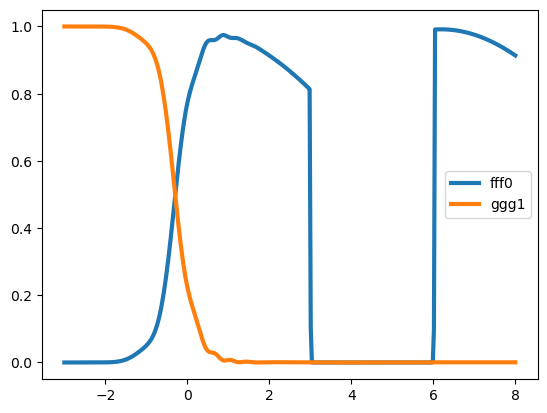

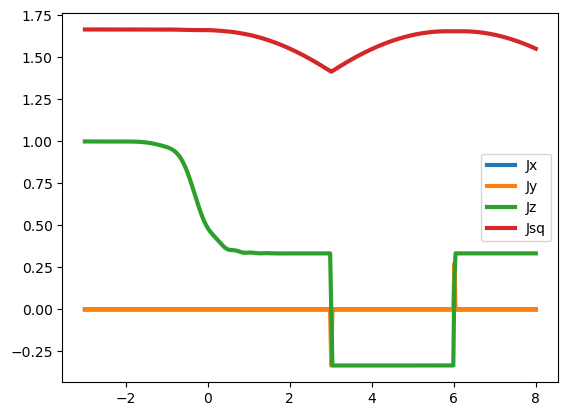

In [36]:
import matplotlib.pyplot as plt
display(max([fidelity(x,dicke2) for x in sts]))
f, ax = plt.subplots()
ax.plot(tlist, np.real([expect(dicke2*dicke2.dag(),x) for x in sts]),label=r'fff0',linewidth=3)
ax.plot(tlist, np.real([expect(ggg0*ggg0.dag(),x) for x in sts]),label=r'ggg1',linewidth=3)
ax.legend()
plt.show()

f, ax = plt.subplots()
ax.plot(tlist, Jx,label=r'Jx',linewidth=3)
ax.plot(tlist, Jy,label=r'Jy',linewidth=3)
ax.plot(tlist, Jz,label=r'Jz',linewidth=3)
ax.plot(tlist, Jsq,label=r'Jsq',linewidth=3)
ax.legend()
#ax.plot(tlist, np.real([expect(sum(y for y in s3_list),x) for x in sts]),label=r'0',linewidth=3)
plt.show()

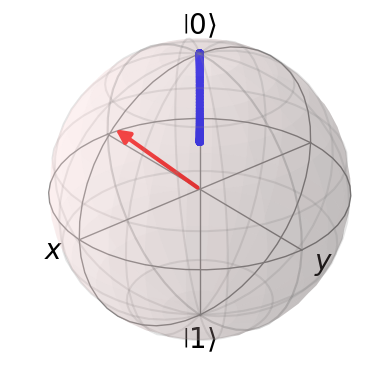

In [7]:
class e_result:
    def __init__(self,tlist,expect):
        self.times = tlist
        self.expect = expect

Dc1.Bloch_animate(filename='bloch_sphere')

Quantum object: dims=[[3, 3, 3, 2], [3, 3, 3, 2]], shape=(54, 54), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.9 0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]

<Result
  Solver: mesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.0
    preparation time: 0.0004048347473144531
    run time: 0.11527061462402344
    solver: 'Master Equation Evolution'
    num_collapse: 0
  Time interval: [0.0, 2.0] (100 steps)
  Number of e_ops: 0
  States saved.
>

In [10]:
from scipy.integrate import quad
gas= lambda t: np.pi*np.sqrt(1/(2*(2**2)*np.pi))*np.exp(-(t-0.0-2)**2/(2*2**2))
quad(gas,-10,10)
np.exp(

(3.1414931523496636, 1.1487625517503375e-08)